# **1. SetUp Environment**

##  **1.1 Installing requirements**

In [1]:
## ======================= Installation ==========================
# Core Jupyter support
!pip install --quiet --upgrade jupyterlab_widgets ipywidgets

# NLP and evaluation metrics
!pip install --quiet --upgrade sacremoses sacrebleu rouge_score textstat

# Hugging Face ecosystem
!pip install --quiet --upgrade datasets evaluate "transformers[sentencepiece]" accelerate bitsandbytes

# LoRA & PEFT
!pip install --quiet --upgrade git+https://github.com/huggingface/peft.git

# EASSE evaluation (Simplification metrics)
!pip install --quiet --upgrade git+https://github.com/feralvam/easse.git


##  **1.2 Importing Necessary libraries**

In [2]:
### ======================= Imports ===============================
import os
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import Dataset
from evaluate import load
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorWithPadding,
    get_scheduler,
    BitsAndBytesConfig,
    set_seed
)

from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model
)

from easse.sari import corpus_sari
import wandb



/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-06-10 13:41:47.310563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 13:41:47.310634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 13:41:47.312580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:

## **1.3 Setup configurations**

In [3]:
# ======================= Configuration =========================
CONFIG = {
    "data_dir": "/kaggle/input/cells-bts/CELLS",
    "checkpoint": "google/flan-t5-small",
    "output_dir": "/kaggle/working/BioTS_V01",
    "batch_size": 4,
    "num_epochs": 2,
    "learning_rate": 5e-4,
    "weight_decay": 5e-3,
    "grad_accum_steps": 16,
    "max_length": 512,
    "lora_r": 32,
    "lora_alpha": 64,
    "lora_dropout": 0.01,
    "use_mixed_precision": False,
    "seed": 42
}

# Set reproducibility
set_seed(CONFIG["seed"])

# Device detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG["checkpoint"])

# Baseline model references
BASELINE_MODELS = {
    "T5-Large": "google/flan-t5-large",
    "FLAN-T5-base": "google/flan-t5-base",
    "PEGASUS": "google/pegasus-large",
    "BART-Large": "facebook/bart-large-cnn",
}

# All available models for comparison
ALL_MODELS = {
    "BioT5-Finetuned": "/kaggle/input/bio_t5_v00/pytorch/default/5/t5-small-biomed",
    **BASELINE_MODELS
}


### ======================= W&B Setup (Optional) ===================
# wandb.init(
#     project="biomedical-text-simplification",
#     name="flan-t5-small-qlora",
#     config=CONFIG
# )


# **2 - Data Preparation** 
* ##  **2.1 Load Data**

In [4]:
# ======================= File Utilities =======================
def read_lines(filepath, limit=None):
    """Reads lines from a file, stripping whitespace."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
    with open(filepath, encoding="utf-8") as f:
        lines = [line.strip() for line in f]
    return lines[:limit] if limit else lines


# ======================= File Paths =======================
file_paths = {
    "train_source": os.path.join(CONFIG['data_dir'], "train.source"),
    "train_target": os.path.join(CONFIG['data_dir'], "train.target"),
    "val_source": os.path.join(CONFIG['data_dir'], "val.source"),
    "val_target": os.path.join(CONFIG['data_dir'], "val.target"),
    "test_source": os.path.join(CONFIG['data_dir'], "test.source"),
    "test_target": os.path.join(CONFIG['data_dir'], "test.target"),
}

# ======================= Data Loading =======================
def load_data(paths, limits):
    """Loads data from files with optional line limits."""
    return {
        key: read_lines(path, limit=limits.get(key))
        for key, path in paths.items()
    }

line_limits = {
    "train_source": 100, "train_target": 100,
    "val_source": 10, "val_target": 10,
    "test_source": 10, "test_target": 10,
}

raw_data = load_data(file_paths, line_limits)



## **2.2 Tokenization**

In [5]:
# ======================= Tokenization =======================
def tokenize_pairs(sources, targets, tokenizer, max_length):
    """Tokenizes source and target texts with padding and truncation."""
    inputs = tokenizer(
        sources,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    targets_enc = tokenizer(
        targets,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return inputs, targets_enc

# ======================= Tokenize =======================
encoded_train = tokenize_pairs(
    raw_data["train_source"], raw_data["train_target"], tokenizer, CONFIG["max_length"])
encoded_val = tokenize_pairs(
    raw_data["val_source"], raw_data["val_target"], tokenizer, CONFIG["max_length"])
encoded_test = tokenize_pairs(
    raw_data["test_source"], raw_data["test_target"], tokenizer, CONFIG["max_length"])

## **2.3. Dataset** 

In [6]:
# ======================= Dataset Creation =======================
def build_hf_dataset(inputs, targets):
    """Builds a Hugging Face Dataset from tokenized input/target tensors."""
    return Dataset.from_dict({
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"]
    })


# ======================= Create Dataset =======================
train_dataset = build_hf_dataset(*encoded_train)
train_dataset = train_dataset.shuffle(seed=42)  # Deterministic shuffle
val_dataset = build_hf_dataset(*encoded_val)
test_dataset = build_hf_dataset(*encoded_test)



## **2.4 DataLoader**

In [ ]:

# ======================= DataLoaders =======================
def create_dataloader(dataset, tokenizer, batch_size, shuffle=False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True,
        drop_last=False,
        collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
    )

train_loader = create_dataloader(train_dataset, tokenizer, CONFIG["batch_size"], shuffle=True)
val_loader   = create_dataloader(val_dataset, tokenizer, CONFIG["batch_size"])
test_loader  = create_dataloader(test_dataset, tokenizer, CONFIG["batch_size"])

# **4. Building Model**

In [ ]:
# ======================= Model Preparation =======================
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(CONFIG["checkpoint"])

model = AutoModelForSeq2SeqLM.from_pretrained(
    CONFIG["checkpoint"],
    quantization_config=bnb_config,
    device_map="auto"
)

model = prepare_model_for_kbit_training(model)

lora_cfg = LoraConfig(
    r=CONFIG["lora_r"],
    lora_alpha=CONFIG["lora_alpha"],
    target_modules=["q", "v"],  # adapter si nécessaire
    lora_dropout=CONFIG["lora_dropout"],
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()


# **5. Fine-tuning**
##  **5.1 Optimizer & lr Scheduler**

In [ ]:
# ======================= Optimizer & Scheduler =======================
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    eps=1e-8,
    weight_decay=CONFIG["weight_decay"]
)

num_training_steps = len(train_loader) * CONFIG["num_epochs"]
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)


- ##  **5.2  Training loop**

In [ ]:
# ======================= Training Loop =======================
def train_and_validate(model, train_loader, val_loader, config):
    train_losses, val_losses = [], []
    train_steps, val_steps = [], []
    global_step = 0

    for epoch in range(config["num_epochs"]):
        model.train()
        total_train_loss = 0.0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False)

        for step, batch in enumerate(train_bar):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss / config["grad_accum_steps"]

            if not torch.isfinite(loss):
                print(f"⚠️ Skipping non-finite loss at step {step}")
                continue

            loss.backward()

            if (step + 1) % config["grad_accum_steps"] == 0 or (step + 1) == len(train_bar):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                lr_scheduler.step()

                train_losses.append(loss.item())
                train_steps.append(global_step)
                global_step += 1

                gc.collect()
                torch.cuda.empty_cache()

            total_train_loss += loss.item()
            train_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        # ========== Validation ==========
        model.eval()
        total_val_loss = 0.0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]", leave=False)

        with torch.no_grad():
            for step, batch in enumerate(val_bar):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss

                if not torch.isfinite(loss):
                    print(f"⚠️ Skipping non-finite val loss at step {step}")
                    continue

                val_losses.append(loss.item())
                val_steps.append(global_step + step)
                total_val_loss += loss.item()
                val_bar.set_postfix({"val_loss": f"{loss.item():.4f}"})

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / max(len(val_loader), 1)

        print(f"\n📘 Epoch {epoch+1} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

        # Uncomment to enable logging
        # wandb.log({
        #     "epoch": epoch + 1,
        #     "train_loss": avg_train_loss,
        #     "val_loss": avg_val_loss,
        #     "lr": lr_scheduler.get_last_lr()[0]
        # })

    return train_losses, val_losses, train_steps, val_steps

# ======================= Run Training =======================
train_losses, val_losses, train_steps, val_steps = train_and_validate(model, train_loader, val_loader, CONFIG)


In [ ]:
print(train_losses)
print(val_losses)
print(train_steps)
print(val_steps )


In [ ]:
def plot_learning_curves(train_losses, val_losses, train_steps, val_steps, output_path="learning_curve_final.png"):
    """
    Plots the training and validation loss curves.
    
    Args:
        train_losses (List[float]): Training loss values.
        val_losses (List[float]): Validation loss values.
        train_steps (List[int]): Steps corresponding to each training loss.
        val_steps (List[int]): Steps corresponding to each validation loss.
        output_path (str): Path to save the figure.
    """
    plt.figure(figsize=(10, 6))

    # Plotting with consistent style and optimized layout
    plt.plot(train_steps, train_losses, label='Training Loss',
             color='steelblue', linewidth=2, marker='o', markersize=4)
    plt.plot(val_steps, val_losses, label='Validation Loss',
             color='darkorange', linewidth=2, marker='s', markersize=4)

    # Labels, title and limits
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training vs Validation Loss", fontsize=14)

    # Dynamic y-axis for better visibility
    all_losses = train_losses + val_losses
    plt.ylim(min(all_losses) * 0.9, max(all_losses) * 1.1)

    # Aesthetic adjustments
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', fontsize=11, frameon=False)

    # Final layout and export
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()
    print(f"📈 Learning curve saved to: {output_path}")




In [ ]:
def save_model_and_tokenizer(model, tokenizer, output_dir):
    """
    Saves the model and tokenizer to the specified output directory.
    
    Args:
        model: Trained Hugging Face model.
        tokenizer: Corresponding tokenizer.
        output_dir (str): Path to save the model and tokenizer.
    """
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"\n✅ Model and tokenizer saved to: {output_dir}")


In [ ]:
# === Post-training visualization and saving ===
plot_learning_curves(train_losses, val_losses, train_steps, val_steps, output_path="learning_curve_final.png")
save_model_and_tokenizer(model, tokenizer, CONFIG['output_dir'])


- ##  **6. Evaluation**

###   ***Computing sari scores***

In [7]:
sari = load("sari")

# =========== Instructing tuning and Few shot examples
instruction_tun_few_shot_prompt = """
You are a biomedical text simplifier. Simplify complex medical texts into plain language.

Example 1: 
Complex: Plants produce a plethora of natural products, including many drugs. It has recently emerged that the genes encoding different natural product pathways may be organized as biosynthetic gene clusters in plant genomes, with >30 examples reported so far. Despite superficial similarities with microbes, these clusters have not arisen by horizontal gene transfer, but rather by gene duplication, neofunctionalization, and relocation via unknown mechanisms. Previously we reported that two Arabidopsis thaliana biosynthetic gene clusters are located in regions of the genome that are significantly enriched in transposable elements (TEs) . Other plant biosynthetic gene clusters also harbor abundant TEs. TEs can mediate genomic rearrangement by providing homologous sequences that enable illegitimate recombination and gene relocation. Thus, TE-mediated recombination may contribute to plant biosynthetic gene cluster formation. TEs may also facilitate establishment of regulons. However, a systematic analysis of the TEs associated with plant biosynthetic gene clusters has not been carried out. Here we investigate the TEs associated with clustered terpene biosynthetic genes in multiple plant genomes and find evidence to suggest a role for miniature inverted-repeat transposable elements in cluster formation in eudicots. Through investigation of the newly sequenced Amborella trichopoda, Aquilegia coerulea, and Kalanchoe fedtschenkoi genomes, we further show that the block mechanism of founding of biosynthetic gene clusters through duplication and diversification of pairs of terpene synthase and cytochrome P450 genes that is prevalent in the eudicots arose around 90-130 million years ago, after the appearance of the basal eudicots and before the emergence of the superrosid clade.
Simple: Significance Recently discovered biosynthetic gene clusters in plants are a striking example of the nonrandom complex structure of eukaryotic genomes. The mechanisms underpinning the formation of these clustered pathways are not understood. Here we carry out a systematic analysis of transposable elements associated with clustered terpene biosynthetic genes in plant genomes, and find evidence to suggest a role for miniature inverted-repeat transposable elements in cluster formation in eudicots. Our analyses provide insights into potential mechanisms of cluster assembly. They also shed light on the emergence of a block mechanism for the foundation of new terpene clusters in the eudicots in which microsyntenic blocks of terpene synthase and cytochrome P450 gene pairs duplicate, providing templates for the evolution of new pathways.

Example 2:   
Complex: Although the use of phylogenetic trees in epidemiological investigations has become commonplace, their epidemiological interpretation has not been systematically evaluated. Here, we use an HIV-1 within-host coalescent model to probabilistically evaluate transmission histories of two epidemiologically linked hosts. Previous critique of phylogenetic reconstruction has claimed that direction of transmission is difficult to infer, and that the existence of unsampled intermediary links or common sources can never be excluded. The phylogenetic relationship between the HIV populations of epidemiologically linked hosts can be classified into six types of trees, based on cladistic relationships and whether the reconstruction is consistent with the true transmission history or not. We show that the direction of transmission and whether unsampled intermediary links or common sources existed make very different predictions about expected phylogenetic relationships: (i) Direction of transmission can often be established when paraphyly exists, (ii) intermediary links can be excluded when multiple lineages were transmitted, and (iii) when the sampled individuals HIV populations both are monophyletic a common source was likely the origin. Inconsistent results, suggesting the wrong transmission direction, were generally rare. In addition, the expected tree topology also depends on the number of transmitted lineages, the sample size, the time of the sample relative to transmission, and how fast the diversity increases after infection. Typically, 20 or more sequences per subject give robust results. We confirm our theoretical evaluations with analyses of real transmission histories and discuss how our findings should aid in interpreting phylogenetic results.
Simple:  Significance Phylogenetic inference of who infected whom has great value in epidemiological investigations because it should provide an objective test of an explicit hypothesis about how transmission( s) occurred. Until now, however, there has not been a systematic evaluation of which phylogeny to expect from different transmission histories, and thus the interpretation of what an observed phylogeny actually means has remained somewhat elusive. Here, we show that certain types of phylogenies associate with different transmission histories, which may make it possible to exclude possible intermediary links or identify cases where a common source was likely but not sampled. Our systematic classification and evaluation of expected topologies should make future interpretation of phylogenetic results in epidemiological investigations more objective and informative.

Now simplify the following sentence:
Complex: {input}
Simple:
"""

In [8]:
# ======================= Prompt Formatting =========================
def  build_instruction_prompts(sources, few_shot=True):
    """Format inputs using few-shot or direct prompt style"""
    return [
        instruction_tun_few_shot_prompt.format(input=src.strip()) if few_shot
        else f"Simplify the following text into plain language:\n{src.strip()}"
        for src in sources
    ]


In [9]:
import torch
import gc
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ========== Generation Logic ==========
def generate_batch_predictions(model, input_ids, tokenizer, batch_size=4, max_new_tokens=256):
    """Efficiently generate predictions in memory-aware batches"""
    model.eval()
    predictions = []

    total = len(input_ids)
    for start in tqdm(range(0, total, batch_size), desc="Generating Predictions"):
        try:
            batch_input = input_ids[start:start + batch_size].to(model.device)
            with torch.no_grad():
                output_ids = model.generate(
                    input_ids=batch_input,
                    max_new_tokens=max_new_tokens,
                    num_beams=5,
                    early_stopping=True,
                    use_cache=True
                )
            decoded_batch = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
            predictions.extend(decoded_batch)
        except RuntimeError as err:
            if 'out of memory' in str(err).lower():
                print(f"⚠️ OOM at batch {start}. Retrying with reduced batch size...")
                torch.cuda.empty_cache()
                gc.collect()
                reduced_batch_size = max(1, batch_size // 2)
                return generate_batch_predictions(model, input_ids, tokenizer, batch_size=reduced_batch_size, max_new_tokens=max_new_tokens)
            raise
        finally:
            del batch_input, output_ids
            torch.cuda.empty_cache()
            gc.collect()

    return predictions

# ========== SARI Metric ==========
def evaluate_sari_performance(sources, predictions, references, chunk_size=500):
    """Compute average and standard deviation of SARI over chunks"""
    from evaluate import load  # On-the-fly import to prevent unnecessary memory use
    sari = load("sari")
    scores = []

    for i in range(0, len(sources), chunk_size):
        src_chunk = sources[i:i + chunk_size]
        pred_chunk = predictions[i:i + chunk_size]
        ref_chunk = references[i:i + chunk_size]

        for src, pred, ref in zip(src_chunk, pred_chunk, ref_chunk):
            score = sari.compute(
                sources=[src],
                predictions=[pred],
                references=[[ref]]
            )["sari"]
            scores.append(score)

    return np.mean(scores), np.std(scores)

# ========== Evaluation Logic ==========
def evaluate_model_sari(
    model_path, sources, references,
    use_instruction_tuning=False, few_shot=True,
    batch_size=4, max_new_tokens=256
):
    """Main evaluation function for SARI using a model checkpoint"""
    model, tokenizer = None, None
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        prompts = build_instruction_prompts(sources, few_shot) if use_instruction_tuning else sources
        tokenized = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt")
        input_ids = tokenized["input_ids"].to(model.device)

        predictions = generate_batch_predictions(model, input_ids, tokenizer, batch_size, max_new_tokens)
        return evaluate_sari_performance(sources, predictions, references)
    finally:
        del model, tokenizer
        torch.cuda.empty_cache()
        gc.collect()

# ========== Retry Wrapper ==========
def retry_on_oom(*args, desc="Evaluation", **kwargs):
    """Retry evaluation once in case of global OOM"""
    try:
        return evaluate_model_sari(*args, **kwargs)
    except RuntimeError as err:
        if 'out of memory' in str(err).lower():
            print(f"⚠️ Global OOM during {desc}. Retrying...")
            torch.cuda.empty_cache()
            gc.collect()
            return evaluate_model_sari(*args, **kwargs)
        raise

# ========== SARI Summary ==========
def display_sari_summary(label, sari_stats):
    mean, std = sari_stats
    print(f"\n== {label} ==")
    print(f"SARI: {mean:.2f} ± {std:.2f}")

# ========== Evaluation Runner ==========
def evaluate_model_on_datasets(
    model_path,
    eval_sets,
    label_prefix="Model",
    instruction_tuned=False,
    few_shot=True
):
    """Evaluate a model on multiple datasets and print summaries"""
    results = {}
    for label, src, ref in eval_sets:
        full_label = f"{label_prefix} - {label}"
        print(f"\n=== {full_label} ===")
        sari_stats = retry_on_oom(
            model_path,
            src,
            ref,
            use_instruction_tuning=instruction_tuned,
            few_shot=few_shot,
            desc=full_label
        )
        results[label] = sari_stats
        display_sari_summary(full_label, sari_stats)
    return results


In [10]:
# Config
checkpoint = "/kaggle/input/bio_t5_v00/pytorch/default/5/t5-small-biomed"

# Entraînement
train_stats = evaluate_model_on_datasets(
    checkpoint,
    eval_sets=[("Train", raw_data["train_source"], raw_data["train_target"])],
    label_prefix="Fine-tuned Model"
)

# Test zero-shot
zero_shot_stats = evaluate_model_on_datasets(
    checkpoint,
    eval_sets=[("Test (Zero-shot)", raw_data["val_source"], raw_data["val_target"])],
    label_prefix="Fine-tuned Model"
)

# Instruction-tuning + few-shot
instruction_stats = evaluate_model_on_datasets(
    checkpoint,
    eval_sets=[("Test (Instruction + Few-shot)", raw_data["val_source"], raw_data["val_target"])],
    label_prefix="Fine-tuned Model",
    instruction_tuned=True,
    few_shot=True
)

# Baselines
baseline_results = {}
for name, path in BASELINE_MODELS.items():
    baseline_results[name] = evaluate_model_on_datasets(
        path,
        eval_sets=[("Test", raw_data["test_source"], raw_data["test_target"])],
        label_prefix=f"Baseline - {name}"
    )



=== Fine-tuned Model - Train ===


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generating Predictions: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s]



== Fine-tuned Model - Train ==
SARI: 30.65 ± 3.69

=== Fine-tuned Model - Test (Zero-shot) ===


Generating Predictions: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]



== Fine-tuned Model - Test (Zero-shot) ==
SARI: 32.82 ± 5.53

=== Fine-tuned Model - Test (Instruction + Few-shot) ===


Generating Predictions: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]



== Fine-tuned Model - Test (Instruction + Few-shot) ==
SARI: 29.98 ± 5.90

=== Baseline - T5-Large - Test ===


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generating Predictions: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]



== Baseline - T5-Large - Test ==
SARI: 34.26 ± 4.52

=== Baseline - FLAN-T5-base - Test ===


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generating Predictions: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]



== Baseline - FLAN-T5-base - Test ==
SARI: 33.61 ± 3.61

=== Baseline - PEGASUS - Test ===


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]


Generating Predictions:   0%|          | 0/3 [00:00<?, ?it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.

Generating Predictions: 100%|██████████| 3/3 [00:10<00:00,  3.67s/it]



== Baseline - PEGASUS - Test ==
SARI: 33.33 ± 2.82

=== Baseline - BART-Large - Test ===


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Generating Predictions: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it]



== Baseline - BART-Large - Test ==
SARI: 36.29 ± 3.32


## **Error Bar Plot for SARI Comparison** 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sari_error_bars(results_dict, title="SARI Comparison Across Models"):
    """
    Plot error bars (mean ± std) for SARI scores across models.
    
    Args:
        results_dict: dict[str, tuple] in the form {label: (mean, std)}
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))

    labels = list(results_dict.keys())
    means = [results_dict[label][0] for label in labels]
    stds = [results_dict[label][1] for label in labels]

    palette = sns.color_palette("muted", len(labels))
    ax = sns.barplot(x=labels, y=means, yerr=stds, palette=palette, capsize=0.2)

    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.text(i, mean + std + 0.5, f"{mean:.2f}±{std:.2f}", ha='center', va='bottom', fontsize=10)

    ax.set_title(title, fontsize=14)
    ax.set_ylabel("SARI Score", fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


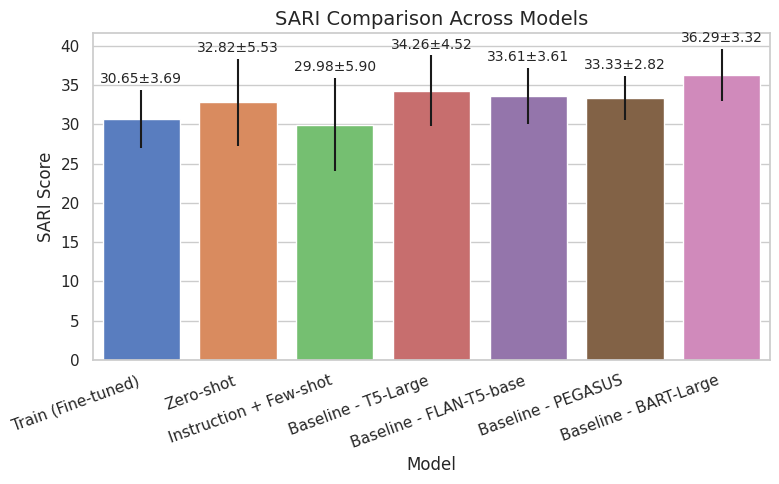

In [12]:
# Combine all results
combined_results = {
    "Train (Fine-tuned)": train_stats["Train"],
    "Zero-shot": zero_shot_stats["Test (Zero-shot)"],
    "Instruction + Few-shot": instruction_stats["Test (Instruction + Few-shot)"]
}
combined_results.update({f"Baseline - {k}": v["Test"] for k, v in baseline_results.items()})

# Plot
plot_sari_error_bars(combined_results)


## **Markdown Summary Table**

In [13]:
def generate_sari_markdown_table(results_dict):
    """
    Generate a Markdown table for SARI mean ± std scores.
    
    Args:
        results_dict: dict[str, tuple] of {label: (mean, std)}
    """
    print("| Model | SARI Mean ± Std |")
    print("|-------|------------------|")
    for label, (mean, std) in results_dict.items():
        print(f"| {label} | {mean:.2f} ± {std:.2f} |")


In [14]:
generate_sari_markdown_table(combined_results)


| Model | SARI Mean ± Std |
|-------|------------------|
| Train (Fine-tuned) | 30.65 ± 3.69 |
| Zero-shot | 32.82 ± 5.53 |
| Instruction + Few-shot | 29.98 ± 5.90 |
| Baseline - T5-Large | 34.26 ± 4.52 |
| Baseline - FLAN-T5-base | 33.61 ± 3.61 |
| Baseline - PEGASUS | 33.33 ± 2.82 |
| Baseline - BART-Large | 36.29 ± 3.32 |


# Evaluating using all Metrics

In [16]:
import os
import gc
import logging
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from evaluate import load
from textstat import flesch_kincaid_grade, gunning_fog, coleman_liau_index
from bert_score import score as bertscore_score


# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Device detection
logger.info(f"Using device: {device}")



class MetricEvaluator:
    """Class to handle evaluation metrics computation."""
    
    def __init__(self):
        self.metrics = {
            "rouge": load("rouge"),
            "bleu": load("bleu"),
            "sari": load("sari")
        }
    
    def compute_readability_scores(self, texts: List[str]) -> Tuple[List[float], List[float], List[float]]:
        """Compute readability scores (FKG, GFI, CLI) for a list of texts."""
        try:
            fkg = [flesch_kincaid_grade(t) for t in texts]
            gfi = [gunning_fog(t) for t in texts]
            cli = [coleman_liau_index(t) for t in texts]
            return fkg, gfi, cli
        except Exception as e:
            logger.error(f"Error computing readability scores: {e}")
            return [], [], []

    def compute_metrics(self, predictions: List[str], references: List[str], sources: List[str]) -> Dict[str, Tuple[float, float]]:
        """Compute evaluation metrics (SARI, ROUGE-L, BLEU, BERTScore, FKG, GFI, CLI)."""
        results = {}
        
        # SARI
        sari_scores = [
            self.metrics["sari"].compute(predictions=[pred], references=[[ref]], sources=[src])["sari"]
            for pred, ref, src in zip(predictions, references, sources)
        ]
        results["SARI"] = (np.mean(sari_scores), np.std(sari_scores))
        
        # ROUGE-L
        rouge_l_scores = [
            self.metrics["rouge"].compute(predictions=[pred], references=[ref])["rougeL"].fmeasure
            for pred, ref in zip(predictions, references)
        ]
        results["ROUGE-L"] = (np.mean(rouge_l_scores), np.std(rouge_l_scores))
        
        # BLEU
        bleu_scores = [
            self.metrics["bleu"].compute(predictions=[pred.split()], references=[[ref.split()]])["bleu"]
            for pred, ref in zip(predictions, references)
        ]
        results["BLEU"] = (np.mean(bleu_scores), np.std(bleu_scores))
        
        # BERTScore
        P, R, F1 = bertscore_score(predictions, references, lang="en", verbose=False)
        results["BERTScore"] = (F1.mean().item(), F1.std().item())
        
        # Readability
        fkg, gfi, cli = self.compute_readability_scores(predictions)
        results["FKG"] = (np.mean(fkg) if fkg else 0.0, np.std(fkg) if fkg else 0.0)
        results["GFI"] = (np.mean(gfi) if gfi else 0.0, np.std(gfi) if gfi else 0.0)
        results["CLI"] = (np.mean(cli) if cli else 0.0, np.std(cli) if cli else 0.0)
        
        return results

class ModelEvaluator:
    """Class to handle model evaluation pipeline."""
    
    def __init__(self, config: Dict):
        self.config = config
        self.evaluator = MetricEvaluator()
    
    def evaluate_model(self, model_name: str, checkpoint: str, sources: List[str], references: List[str], 
                      format_fn) -> Tuple[str, Dict[str, Tuple[float, float]]]:
        """Evaluate a single model."""
        logger.info(f"Evaluating model: {model_name}")
        
        try:
            # Load tokenizer and model
            tokenizer = AutoTokenizer.from_pretrained(checkpoint)
            model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(device)
            
            # Format and tokenize inputs
            inputs = tokenizer(
                format_fn(sources),
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=self.config["max_length"]
            ).input_ids.to(device)
            
            # Generate predictions
            predictions = generate_batch_predictions(
                model, inputs, tokenizer, 
                batch_size=self.config["batch_size"], 
                max_new_tokens=self.config["max_length"]
            )
            
            # Compute metrics
            results = self.evaluator.compute_metrics(predictions, references, sources)
            
            # Clean up
            del model, tokenizer, inputs
            torch.cuda.empty_cache()
            gc.collect()
            
            return model_name, results
        
        except Exception as e:
            logger.error(f"Error evaluating model {model_name}: {e}")
            return model_name, {}
    
    def evaluate_all_models(self, models: Dict[str, str], sources: List[str], references: List[str], 
                           format_fn) -> Dict[str, Dict[str, Tuple[float, float]]]:
        """Evaluate all models and return summary."""
        return {
            name: self.evaluate_model(name, path, sources, references, format_fn)[1]
            for name, path in models.items()
        }

class ResultFormatter:
    """Class to format and visualize results."""
    
    @staticmethod
    def generate_latex_table(results_summary: Dict[str, Dict[str, Tuple[float, float]]]) -> str:
        """Generate LaTeX table for publication."""
        metrics = list(next(iter(results_summary.values())).keys())
        df = pd.DataFrame({
            "Model": list(results_summary.keys()),
            **{
                metric: [
                    f"{results_summary[model][metric][0]:.3f} ± {results_summary[model][metric][1]:.3f}"
                    for model in results_summary
                ] for metric in metrics
            }
        })
        
        # Generating LaTeX table
        latex_table = (
            "\\begin{table}[h]\n"
            "\\centering\n"
            "\\caption{Model Comparison on Biomedical Text Simplification Metrics}\n"
            "\\label{tab:model_comparison}\n"
            "\\begin{tabular}{l" + "c" * len(metrics) + "}\n"
            "\\toprule\n"
            "Model & " + " & ".join(metrics) + " \\\\\n"
            "\\midrule\n"
        )
        for _, row in df.iterrows():
            latex_table += f"{row['Model']} & " + " & ".join(row[metrics]) + " \\\\\n"
        latex_table += (
            "\\bottomrule\n"
            "\\end{tabular}\n"
            "\\end{table}"
        )
        return latex_table
    
    @staticmethod
    def plot_results(results_summary: Dict[str, Dict[str, Tuple[float, float]]], 
                     save_path: str = "model_comparison_plot.pdf") -> None:
        """Generate and save a bar plot for model comparison."""
        # Prepare data
        data = [
            {"Model": model, "Metric": metric, "Mean": mean, "Std": std}
            for model, metrics in results_summary.items()
            for metric, (mean, std) in metrics.items()
        ]
        df = pd.DataFrame(data)
        
        # Set style
        sns.set(style="whitegrid", context="paper", palette="muted", font_scale=1.2)
        
        # Plot setup
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(
            data=df, x="Model", y="Mean", hue="Metric",
            dodge=True, edgecolor="black"
        )
        
        # Add error bars
        model_names = df["Model"].unique()
        metric_names = df["Metric"].unique()
        total_metrics = len(metric_names)
        bar_width = 0.8 / total_metrics
        
        for _, row in df.iterrows():
            group_idx = list(model_names).index(row["Model"])
            metric_idx = list(metric_names).index(row["Metric"])
            x_pos = group_idx - 0.4 + bar_width * (metric_idx + 0.5)
            ax.errorbar(x=x_pos, y=row["Mean"], yerr=row["Std"], 
                       fmt='none', ecolor='black', capsize=4, lw=1.2)
        
        # Formatting
        plt.title("Model Comparison on Biomedical Text Simplification", fontsize=14)
        plt.ylabel("Mean Score", fontsize=12)
        plt.xlabel("Model", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Metric", title_fontsize=11, fontsize=10, loc="upper right")
        plt.tight_layout()
        
        # Save and show
        if os.path.splitext(save_path)[1] not in [".png", ".pdf", ".svg"]:
            logger.warning(f"Unsupported file format for {save_path}. Defaulting to .pdf")
            save_path = "model_comparison_plot.pdf"
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()

def main():
    """Main function to run the evaluation pipeline."""
    # Initialize evaluator
    evaluator = ModelEvaluator(CONFIG)
    
    # Load test data (assumed from context)
    test_source = raw_data["test_source"]
    test_target = raw_data["test_target"]
    all_models = ALL_MODELS  # Assumed from context
    
    # Evaluate models
    results_summary = evaluator.evaluate_all_models(
        all_models, test_source, test_target, build_instruction_prompts
    )
    
    # Format and output results
    formatter = ResultFormatter()
    latex_table = formatter.generate_latex_table(results_summary)
    formatter.plot_results(results_summary)
    
    # Save LaTeX table
    with open(os.path.join(CONFIG["output_dir"], "results_table.tex"), "w") as f:
        f.write(latex_table)

if __name__ == "__main__":
    main()

Generating Predictions: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating Predictions: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


ValueError: Could not interpret input 'Model'

<Figure size 1200x600 with 0 Axes>